# Import Libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import (DecisionTreeClassifier as DTC,
                          DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.metrics import (accuracy_score,
                             log_loss)
from sklearn.ensemble import \
     (RandomForestRegressor as RF,
      GradientBoostingRegressor as GBR)
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from ISLP.bart import BART
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [28]:
from tqdm.auto import tqdm
from lightgbm import LGBMRegressor
import lightgbm as lgb


# Data Loading

In [29]:
# Set pandas display options for better viewing
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

df=pd.read_csv('Ocean_Health_Index_2018_global_scores.csv')
print(df)

     OBJECTID rgn_typ  rgn_id              rgn_nam rgn_key       are_km2  \
0           1     eez       1        Cocos Islands     CCK  4.701166e+05   
1           2     eez      10                Nauru     NRU  3.105651e+05   
2           3     eez     100  Republique du Congo     COG  3.986360e+04   
3           4     eez     101              Namibia     NAM  5.627276e+05   
4           5     eez     102         South Africa     ZAF  1.069378e+06   
..        ...     ...     ...                  ...     ...           ...   
214       218     eez      95     Falkland Islands     FLK  5.490917e+05   
215       219     eez      96         Sierra Leone     SLE  1.604526e+05   
216       220     eez      97              Liberia     LBR  2.477677e+05   
217       221     eez      98                 Togo     TGO  1.552131e+04   
218       222     eez      99                Benin     BEN  3.041927e+04   

        AO     BD     CP     CS     CW     ECO    FIS     FP     HAB    ICO  \
0    96.

In [30]:
model_numerical = df.select_dtypes(include=np.number)
model = MS(model_numerical.columns.drop(['CW', 'Shape__Area', 'Shape__Length', 'Index_', 'OBJECTID', 'rgn_id']), intercept=False) ## drop the outcome variable
D = model.fit_transform(df)
feature_names = list(D.columns)
X = np.asarray(D)

# Data Split for training and testing

In [31]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                model_numerical['CW'],
                                test_size=0.3,
                                random_state=0)

# Model Training

In [32]:
lgbm_ocean = LGBMRegressor(n_estimators=100,
                         random_state=0, n_jobs=-1)
lgbm_ocean.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 808
[LightGBM] [Info] Number of data points in the train set: 153, number of used features: 19
[LightGBM] [Info] Start training from score 62.558366
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [33]:
feature_imp = pd.DataFrame(
    {'importance':lgbm_ocean.feature_importances_},
    index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

,importance
are_km2,52
ICO,37
TR,36
SPP,35
AO,35
CS,34
CP,29
trnd_sc,28
SP,27
MAR,24


In [34]:
y_hat_boost = lgbm_ocean.predict(X_test)

mse = np.mean((y_test - y_hat_boost)**2)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 126.87278476092494


# Data Visualisation of One tree

<Figure size 2500x2000 with 0 Axes>

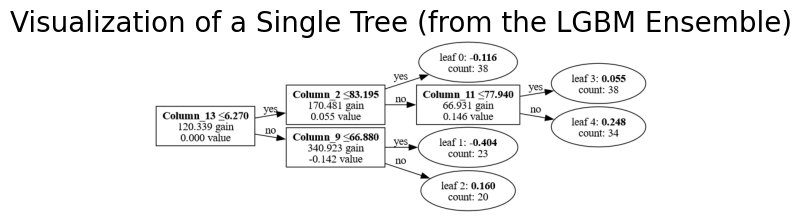

In [36]:
plt.figure(figsize=(25, 20))
lgb.plot_tree(lgbm_ocean, 
              tree_index=49,  # Pick which tree from the sequence to plot
              show_info=['split_gain', 'internal_value', 'leaf_count'],
              precision=3)

plt.title("Visualization of a Single Tree (from the LGBM Ensemble)", fontsize=20)
plt.show()